In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib import dates as pltdates

In [3]:
airlineCode, airlineID, source, sourceID, destination, destinationID, codeshare, stops, equipment = np.loadtxt("../data/routes.csv",delimiter=",",unpack=True,dtype='U',encoding='utf8')

ap_city,ap_country,iata,icao = np.loadtxt("../data/airports.csv",delimiter=",",usecols=[2,3,4,5],unpack=True,dtype='U',encoding='utf8')

ind_airports_iata = iata[(ap_country=="India")]  # List of all Indian airports

# Some extra commas are causing trouble, should fix it
ind_airports_iata = np.array([w.replace('"', '') for w in ind_airports_iata])
ap_city = np.array([w.replace('"', '') for w in ap_city])
ap_country = np.array([w.replace('"', '') for w in ap_country])
iata = np.array([w.replace('"', '') for w in iata])
icao = np.array([w.replace('"', '') for w in icao])

list_iap = [] ## List of Indian Airports

for i in range(0,len(ind_airports_iata)):
    if(ind_airports_iata[i]!="\\N"):
        list_iap.append(ind_airports_iata[i])


list_fap = []

for i in range(0,len(list_iap)):
    all_origins = source[(destination==list_iap[i])] # Find all flights to an Indian airport i
    
    temp_list=[]
    for o in all_origins:
        if (o not in list_iap):
            temp_list.append(o)
    
    list_fap.append(temp_list)

list_fc = []

for i in range(0,len(list_fap)):
    temp_list=[]
    for j in range(0,len(list_fap[i])):
        temp_name = ap_country[np.where(iata==list_fap[i][j])]
        if(len(temp_name)== 0):
            print("Airport with code" + list_fap[i][j] + " not found!")
        else:
            temp_list.append(temp_name[0])
    list_fc.append(temp_list)

    
## Collect the country-wise ban data

ban_country, ban_date = np.loadtxt("../data/ban_data.csv",delimiter=",",usecols=[0,1],unpack=True,dtype='U',encoding='utf8')

# ### Today's date ###

# today = datetime.now().strftime("%Y")+now.strftime("%m")+now.strftime("%d")

# print(today)

ppl_per_flt = 200

def Dij(fcs,t):
    temp_list = []
    for j in range(0,len(fcs)):
        if(fcs[j]=="Hong Kong"):
            ctry = "China"
        elif(fcs[j]=="Yemen" or fcs[j]=="Burma"  or fcs[j]=="Turkmenistan" or fcs[j]=="Tajikistan" or fcs[j]=="Reunion"):
            ctry = "Other"
        else:
            ctry = fcs[j]
        
        ctry_ind = np.where(ban_country==ctry)
        #print(ctry)

        if(len(ctry_ind[0])==0):
            print("Country " + ctry + " not found.")
            temp_list.append("-")
        else:
            index = ctry_ind[0][0]
            #temp_list.append(ban_date[index])
            #print(int(ban_date[index]))
            
            if(int(ban_date[index])<t):
                temp_list.append(int(ppl_per_flt))
            else:
                temp_list.append(int(0))
    
    return np.array(temp_list)
        

## Collect the day-wise confirmed cases data

# Finding total number of columns N

with open("../data/infected_data.csv", 'rb') as f:
    line = next(f) # read 1 line
    N = len(line.split(b','))

#######


dates = np.loadtxt("../data/infected_data.csv",delimiter=",",usecols=np.arange(1,N-1),unpack=True,dtype='int64')[:,0]
countries = np.loadtxt("../data/infected_data.csv",delimiter=",",skiprows=1,usecols=(0),unpack=True,dtype='U')
countrywise_infected = np.loadtxt("../data/infected_data.csv",delimiter=",",skiprows=1,usecols=np.arange(1,N-1),unpack=True,dtype='U')

pop_country, pop_travelling = np.loadtxt("../data/pop_data.csv",delimiter=",",usecols=(0,1),unpack=True,dtype='U')

def pj(fcs, t):
    temp_list = []
    
    try:
        col = np.where(dates==t)[0][0]
        
        for j in range(0,len(fcs)):
            if(fcs[j]=="Hong Kong"):
                ctry = "China"
            elif(fcs[j]=="Yemen" or fcs[j]=="Burma" or fcs[j]=="Turkmenistan"or fcs[j]=="Tajikistan" or fcs[j]=="Maldives"  or fcs[j]=="Reunion"):
                ctry = "Other"
            else:
                ctry = fcs[j]
        
            try:
                
                row = np.where(countries==ctry)[0][0]
                
                total_pop_index = np.where(pop_country==ctry)[0][0]
                total_pop = float(pop_travelling[total_pop_index])
                #print(total_pop)
                
                temp_list.append(float(countrywise_infected[col][row])/total_pop)
            except IndexError:
                print("Country " + ctry + " not found!")
            
    except IndexError:
        print("Date invalid!")
    
    return np.array(temp_list)


### Defining the detection probability at Indian airports

def q(t):
    if(t<=20200131):
        return 0                # Detection probability in Jan
    elif(20200131<t<=20200229):
        return 0.25             # Detection probability in Feb
    elif(20200229<t<=20200331):
        return 0.50             # Detection probability in Feb
    

inf_at_t = []

for t in dates:
    ans = 0.0
    for i in range(0,len(list_fc)):
        if(len(list_fc[i])==0):
            ans = ans + 0
        else:
            Dijpj = np.sum(Dij(list_fc[i],t)*pj(list_fc[i],t))
            ans = ans+Dijpj
            
    inf_at_t.append(ans*(1-q(t)))

#print(inf_at_t)
        

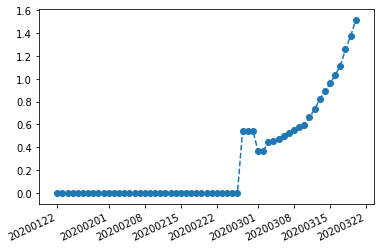

In [4]:
datelist=[]

for d in dates:
    datelist.append(str(d))

converted_dates = list(map(datetime.strptime, datelist, len(datelist)*['%Y%m%d']))
x_axis = converted_dates
formatter = pltdates.DateFormatter('%Y%m%d')

y_axis = inf_at_t

plt.plot(x_axis,y_axis,linestyle='--')
plt.scatter(x_axis,y_axis)


ax = plt.gcf().axes[0] 
ax.xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate(rotation=25)
plt.show()

In [6]:
def SIR(inf):
    # Total population, N.
    N = 2e9
    # Initial number of infected and recovered individuals, I0 and R0.
    I0, R0 = inf, 0
    # Everyone else, S0, is susceptible to infection initially.
    S0 = N - I0 - R0
    # Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
    beta, gamma = 2.4/20, 1./20 
    # A grid of time points (in days)
    t = np.linspace(0, 500, 500)

    # The SIR model differential equations.
    def deriv(y, t, N, beta, gamma):
        S, I, R = y
        dSdt = -beta * S * I / N
        dIdt = beta * S * I / N - gamma * I
        dRdt = gamma * I
        return dSdt, dIdt, dRdt

    # Initial conditions vector
    y0 = S0, I0, R0
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma))
    S, I, R = ret.T

    return S/N,I/N,R/N,t

No handles with labels found to put in legend.


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

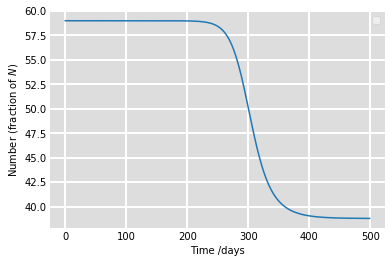

In [25]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (fraction of $N$)')
#ax.set_ylim(0,3.2)#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
# ax.plot(t+i, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
# ax.plot(t+i, I/N, 'r', alpha=0.5, lw=2, label='Infected')
# ax.plot(t+i, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')

final_sus = np.zeros((500,len(dates)),float)
final_inf = np.zeros((500,len(dates)),float)
final_rec = np.zeros((500,len(dates)),float)
sum_sus = []
sum_inf = []
sum_rec = []


for i in range(0,len(dates)):
    S,I,R,t=SIR(inf_at_t[i])
    
    for j in range(0,len(I)):
        final_inf[j,i] = S[j]
print(final_inf[:,1])

for i in range(0,500):
    #sum_sus.append(np.sum(final_sus[i,:]))
    sum_inf.append(np.sum(final_inf[i,:]))
    #sum_rec.append(np.sum(final_rec[i,:]))

#plt.plot(sum_sus)
plt.plot(sum_inf)
#plt.plot(sum_rec)


plt.show()

In [135]:
for i in range(0,len(inf_at_t)):
    SIR(i,dates[i])
plt.show()


TypeError: SIR() takes 1 positional argument but 2 were given

In [54]:
S,I,R,t = SIR(3,0)
#print(t)

#plt.plot(t,S)
#plt.plot(t,I)
#plt.plot(t,R)


In [127]:
len(final_sum)

59